# Predicting the Best Device for Quantum Circuits

Different quantum devices have varying architectures and characteristics. In this tutorial, we'll explore a simpler approach: using machine learning to predict which device is best suited for a given quantum circuit based on the circuit characteristics.

## The Goal

Now that we've seen how to compile circuits for different architectures, we can use the full range of available circuits from MQT Bench to train an ML model that predicts the best device for a given circuit.

We'll compile for two superconducting devices:
- **IQM Crystal** (20 qubits)
- **IBM Falcon** (27 qubits)

We will use the compiled circuit depth as our optimization criterion. Lower depth typically means faster execution and fewer errors.

In [20]:
from mqt.bench.benchmarks import get_benchmark_catalog

print("Available benchmarks: \n")
for str, name in get_benchmark_catalog().items():
    print(f"{str}: {name}")

Available benchmarks: 

ae: Amplitude Estimation
bmw_quark_cardinality: Cardinality Circuit (QUARK)
bmw_quark_copula: Copula Circuit (QUARK)
bv: Bernstein-Vazirani
cdkm_ripple_carry_adder: Cuccaro-Draper-Kutin-Moulton (CDKM) Ripple-Carry Adder
dj: Deutsch-Jozsa
draper_qft_adder: Draper QFT Adder
full_adder: Full Adder
ghz: GHZ State
graphstate: Graph State
grover: Grover's Algorithm
half_adder: Half Adder
hhl: Harrow-Hassidim-Lloyd Algorithm (HHL)
hrs_cumulative_multiplier: Häner-Roetteler-Svore (HRS) Cumulative Multiplier
modular_adder: Modular Adder
multiplier: Multiplier
qaoa: Quantum Approximation Optimization Algorithm (QAOA)
qft: Quantum Fourier Transformation (QFT)
qftentangled: QFT with GHZ state input
qnn: Quantum Neural Network (QNN)
qpeexact: Quantum Phase Estimation (QPE) exactly representable phase
qpeinexact: Quantum Phase Estimation (QPE) not exactly representable phase
qwalk: Quantum Walk
randomcircuit: Random Quantum Circuit
rg_qft_multiplier: Ruiz-Garcia (RG) QFT Mult

In [21]:
from mqt.bench.targets import get_available_device_names

for name in get_available_device_names():
    print(name)

ibm_eagle_127
ibm_falcon_127
ibm_falcon_27
ibm_heron_133
ibm_heron_156
ionq_aria_25
ionq_forte_36
iqm_crystal_20
iqm_crystal_5
iqm_crystal_54
quantinuum_h2_56
rigetti_ankaa_84


In [22]:
from mqt.bench.targets import get_device

iqm_device = get_device("iqm_crystal_20")
ibm_device = get_device("ibm_falcon_27")

## Compile Circuits for Both Devices

Let's compile all available benchmark circuits for both devices:

In [23]:
from mqt.bench import get_benchmark, BenchmarkLevel

num_qubits = 6

raw_circuits = []
iqm_circuits = []
ibm_circuits = []

for str in get_benchmark_catalog().keys():
    try:
        raw_circ = get_benchmark(str, BenchmarkLevel.ALG, circuit_size=num_qubits)
        compiled_iqm_circ = get_benchmark(str, BenchmarkLevel.MAPPED, target=iqm_device, circuit_size=num_qubits)
        compiled_ibm_circ = get_benchmark(str, BenchmarkLevel.MAPPED, target=ibm_device, circuit_size=num_qubits)
    except Exception as e:
        print(f"Skipping {str} due to error: {e}")
        continue
    
    raw_circuits.append(raw_circ)
    iqm_circuits.append(compiled_iqm_circ)
    ibm_circuits.append(compiled_ibm_circ)

Skipping half_adder due to error: num_qubits must be an odd integer ≥ 3.
Skipping hrs_cumulative_multiplier due to error: num_qubits must be an integer ≥ 5 and (num_qubits - 1) must be divisible by 4.
Skipping multiplier due to error: num_qubits must be an integer ≥ 4 and divisible by 4.
Skipping rg_qft_multiplier due to error: num_qubits must be an integer ≥ 4 and divisible by 4.
Skipping shor due to error: No Shor instance for circuit_size=6. Available: 18, 42, 58, 74.
Skipping vbe_ripple_carry_adder due to error: num_qubits must be an integer ≥ 4 and (num_qubits - 1) must be divisible by 3.
Skipping rg_qft_multiplier due to error: num_qubits must be an integer ≥ 4 and divisible by 4.
Skipping shor due to error: No Shor instance for circuit_size=6. Available: 18, 42, 58, 74.
Skipping vbe_ripple_carry_adder due to error: num_qubits must be an integer ≥ 4 and (num_qubits - 1) must be divisible by 3.


## Extract Features and Labels

Now we can create a feature and label set:
- **Features**: Gate counts from the original circuit (number of single-qubit gates, two-qubit gates, etc.)
- **Labels**: Which device produces lower compiled circuit depth (0 = IQM, 1 = IBM)

In [24]:
import numpy as np
import pandas as pd

# Extract features (gate counts) and labels (best device based on depth)
features = []
labels = []
circuit_names = []

# List of all OpenQASM 2.0 standard gates
openqasm2_gates = [
    'id', 'u', 'u1', 'u2', 'u3', 'p', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'rx', 'ry', 'rz', 'sx', 'sxdg', 'cx', 'cy', 'cz', 'cp', 'crx', 'cry', 'crz', 'ch', 'swap', 'ccx', 'cswap', 'cu', 'cu1', 'cu3', 'rxx', 'rzz', 'rccx', 'rc3x', 'c3x', 'c3sqrtx', 'c4x', 'measure', 'barrier', 'reset'
]

for i, (raw_circ, iqm_circ, ibm_circ) in enumerate(zip(raw_circuits, iqm_circuits, ibm_circuits)):
    # Get gate counts from raw circuit
    gate_counts = raw_circ.count_ops()
    
    # Create feature vector with all OpenQASM 2 gates (pad with 0s for missing gates)
    feature_dict = {gate: gate_counts.get(gate, 0) for gate in openqasm2_gates}
    feature_dict['total_gates'] = sum(gate_counts.values())
    
    features.append(feature_dict)
    
    # Determine best device (iqm or ibm) based on compiled depth
    iqm_depth = iqm_circ.depth()
    ibm_depth = ibm_circ.depth()
    labels.append('iqm' if iqm_depth <= ibm_depth else 'ibm')
    circuit_names.append(raw_circ.name)

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(features)
df['best_device'] = labels
df['circuit_name'] = circuit_names

print(f"Total circuits: {len(df)}")
df.head()

Total circuits: 25


,id,u,u1,u2,u3,p,x,y,z,h,...,rc3x,c3x,c3sqrtx,c4x,measure,barrier,reset,total_gates,best_device,circuit_name
0,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,6,1,0,20,ibm,ae
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,6,7,0,70,ibm,bmw_quark_cardinality
2,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,6,4,0,64,iqm,bmw_quark_copula
3,0,0,0,0,0,0,1,0,0,10,...,0,0,0,0,5,0,0,18,iqm,bv
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,6,1,0,12,ibm,cdkm_ripple_carry_adder


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare features and labels
X = df.drop(['best_device', 'circuit_name'], axis=1)
y = df['best_device']

# Split into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
rf_classifier.fit(X_train, y_train)

# Make predictions on both train and test sets
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Evaluate model performance on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Training Set Accuracy: {train_accuracy:.2%}")
print(f"Test Set Accuracy: {test_accuracy:.2%}\n")
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['IBM Falcon', 'IQM Crystal']))

Training Set Accuracy: 100.00%
Test Set Accuracy: 62.50%

Test Set Classification Report:
              precision    recall  f1-score   support

  IBM Falcon       0.80      0.67      0.73         6
 IQM Crystal       0.33      0.50      0.40         2

    accuracy                           0.62         8
   macro avg       0.57      0.58      0.56         8
weighted avg       0.68      0.62      0.65         8



### Results

Let's look at the confusion matrices for both training and test sets:

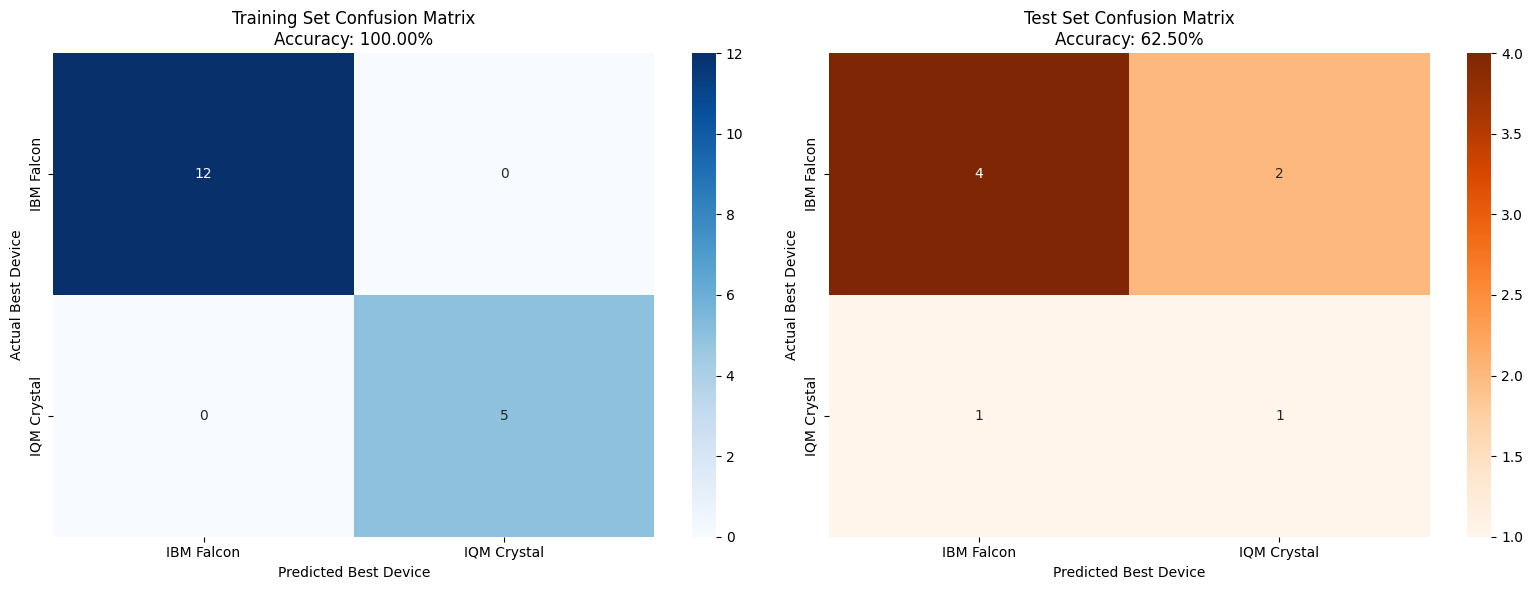

In [32]:
# Plot confusion matrices for both train and test sets
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['IBM Falcon', 'IQM Crystal'],
            yticklabels=['IBM Falcon', 'IQM Crystal'])
axes[0].set_ylabel('Actual Best Device')
axes[0].set_xlabel('Predicted Best Device')
axes[0].set_title(f'Training Set Confusion Matrix\nAccuracy: {train_accuracy:.2%}')

# Test set confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['IBM Falcon', 'IQM Crystal'],
            yticklabels=['IBM Falcon', 'IQM Crystal'])
axes[1].set_ylabel('Actual Best Device')
axes[1].set_xlabel('Predicted Best Device')
axes[1].set_title(f'Test Set Confusion Matrix\nAccuracy: {test_accuracy:.2%}')

plt.tight_layout()
plt.show()

## Inspiration for further tasks:

- Use different circuit features, e.g. based on the cirucit graph structure to imporve the prediction performance: https://arxiv.org/abs/2310.06889